# Landing One

## Fuzzy Matching
* Task: You will receive two datasets with customer information and transactions.
* Objective: Use fuzzy matching techniques to merge these datasets, correcting typographical errors in customer names.
* Tools: Python (libraries for fuzzy matching, e.g., fuzzywuzzy).

In [2]:
import pandas as pd
from fuzzywuzzy import process

In [3]:
customers = pd.read_csv('data/customers.csv')
transactions = pd.read_csv('data/transactions.csv')

In [4]:
customers.head()

,customer_id,customer_name,email
0,1,John Smith,john.smith@email.com
1,2,Jane Doe,jane.doe@email.com
2,3,Micheal Jonson,m.johnson@email.com
3,4,Chris Lee,c.lee@email.com
4,5,Katherine Davis,k.davis@email.com


In [5]:
transactions.head()

,transaction_id,customer_name,amount,transaction_date
0,101,John Smith,784,2023-01-31
1,102,Jane Doe,659,2023-02-28
2,103,Michael Jonson,729,2023-03-31
3,104,Chris Lee,292,2023-04-30
4,105,Katherine Davis,935,2023-05-31


In [6]:
names = customers['customer_name'].tolist()
matches = transactions['customer_name'].apply(lambda x: process.extractOne(x, names, score_cutoff=90))
transactions['match'] = matches.apply(lambda x: x[0])
transactions = transactions.drop(columns=['customer_name'])
consolidated = pd.merge(customers, transactions, left_on='customer_name', right_on='match')
consolidated = consolidated.drop(columns=['match'])

In [7]:
consolidated

,customer_id,customer_name,email,transaction_id,amount,transaction_date
0,1,John Smith,john.smith@email.com,101,784,2023-01-31
1,2,Jane Doe,jane.doe@email.com,102,659,2023-02-28
2,3,Micheal Jonson,m.johnson@email.com,103,729,2023-03-31
3,4,Chris Lee,c.lee@email.com,104,292,2023-04-30
4,5,Katherine Davis,k.davis@email.com,105,935,2023-05-31
5,6,David Martinez,d.martinez@email.com,106,863,2023-06-30
6,7,Sara Brownn,s.brown@email.com,107,807,2023-07-31
7,8,James Wilson,j.wilson@email.com,108,459,2023-08-31
8,9,Patricia Taylor,p.taylor@email.com,109,109,2023-09-30
9,10,Robert Miller,r.miller@email.com,110,823,2023-10-31


## Snowflake Storage and Queries
* Task: Load the merged dataset into Snowflake.
* Objective: Execute SQL queries to generate a consolidated report on buying patterns.
* Tools: Snowflake (SQL for querying).

````
WITH customer_summary AS (
    SELECT
        customer_id,
        customer_name,
        email,
        COUNT(transaction_id) AS transactions,
        SUM(amount) AS total_spent,
        MIN(transaction_date) AS first_purchase_date,
        MAX(transaction_date) AS last_purchase_date
    FROM
        consolidated
    GROUP BY
        customer_id
)

SELECT
    customer_id,
    customer_name,
    email,
    transactions,
    total_spent,
    first_purchase_date,
    last_purchase_date,
    DATEDIFF('day', first_purchase_date, last_purchase_date) AS days_between_first_and_last_purchase,
    ROUND(total_spent / transactions, 2) AS avg_spent_per_transaction
FROM
    customer_summary
ORDER BY
    total_spent DESC;

## Analysis in Jupyter Notebook
* Task: Analyze the merged data in Jupyter Notebook.
* Objective: Identify trends and patterns, and document findings.
* Tools: Python (Matplotlib or Seaborn for visualizations).

In [8]:
consolidated['transaction_date'] = pd.to_datetime(consolidated['transaction_date'])

In [9]:
consolidated

,customer_id,customer_name,email,transaction_id,amount,transaction_date
0,1,John Smith,john.smith@email.com,101,784,2023-01-31
1,2,Jane Doe,jane.doe@email.com,102,659,2023-02-28
2,3,Micheal Jonson,m.johnson@email.com,103,729,2023-03-31
3,4,Chris Lee,c.lee@email.com,104,292,2023-04-30
4,5,Katherine Davis,k.davis@email.com,105,935,2023-05-31
5,6,David Martinez,d.martinez@email.com,106,863,2023-06-30
6,7,Sara Brownn,s.brown@email.com,107,807,2023-07-31
7,8,James Wilson,j.wilson@email.com,108,459,2023-08-31
8,9,Patricia Taylor,p.taylor@email.com,109,109,2023-09-30
9,10,Robert Miller,r.miller@email.com,110,823,2023-10-31


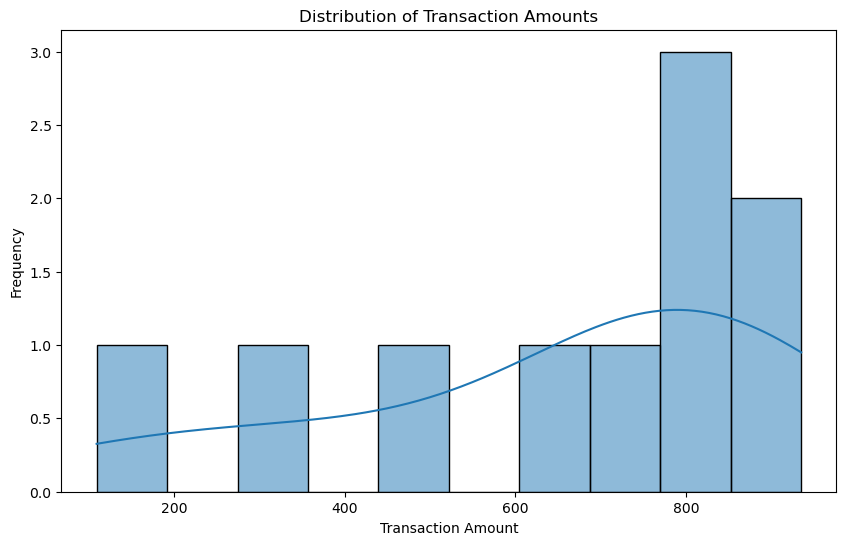

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(consolidated['amount'], kde=True, bins=10)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

In [15]:
top_spenders = consolidated.groupby('customer_name')['amount'].sum().sort_values(ascending=False).head(5)
print(top_spenders)

customer_name
Katherine Davis    935
David Martinez     863
Robert Miller      823
Sara Brownn        807
John Smith         784
Name: amount, dtype: int64


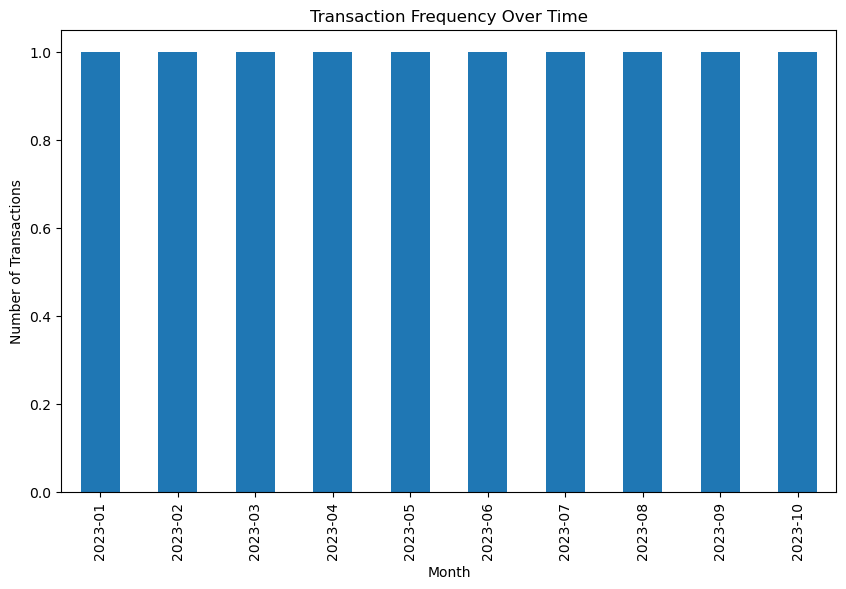

In [16]:
# Group by month
consolidated['month'] = consolidated['transaction_date'].dt.to_period('M')
monthly_transactions = consolidated.groupby('month').size()

# Plot the transaction frequency
plt.figure(figsize=(10, 6))
monthly_transactions.plot(kind='bar')
plt.title('Transaction Frequency Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

In [17]:
customer_transactions = consolidated.groupby('customer_name').size()
repeat_customers = customer_transactions[customer_transactions > 1]
print(f'Number of repeat customers: {len(repeat_customers)}')

Number of repeat customers: 0
